In [1]:
import sys
sys.path.append("../SpikeCounter")
import numpy as np
import skimage.io as skio
import matplotlib as mpl
import matplotlib.pyplot as plt
from tifffile import imsave
import matplotlib.colors as colors
import matplotlib.patches as patches
import os
from scipy import interpolate, optimize, ndimage, stats, signal
from skimage import filters, transform, morphology, exposure, measure
from spikecounter.analysis import traces, images
from spikecounter.ui import visualize
from spikecounter import utils
import colorcet as cc
from cycler import cycler
from scipy.io import loadmat
import mat73
from sklearn.utils.extmath import randomized_svd
import pandas as pd
import importlib
from statannotations.Annotator import Annotator

import seaborn as sns
plt.style.use("/n/home11/bjia/bio_publications.mplstyle")

In [2]:
def reload_libraries():
    importlib.reload(images)
    importlib.reload(traces)
    importlib.reload(utils)

In [3]:
figdir = "/n/cohen_lab/Lab/Papers/2022 First Heartbeat/Figures/v8"

### Load metadata and video

In [4]:
reload_libraries()

In [5]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20220208_drbj009_prebeat_excitability_waveprop/"
subfolder = "corrected"
os.makedirs(os.path.join(rootdir, "analysis"), exist_ok=True)

In [6]:
def prep_expt_metadata(rootdir):
    if not os.path.isdir(os.path.join(rootdir, "analysis")):
        os.mkdir(os.path.join(rootdir, "analysis"))
    expt_info = utils.process_experiment_metadata(pd.read_csv(os.path.join(rootdir, "analysis", "experiment_data.csv")),\
                                             regexp_dict={"embryo": r"(?<=E)\d+(?=_)",
                                                         "target": r"(?<=target)\d+",
                                                         "fullfov": r"fullfov",
                                                         "endogenous": r"endogenous",
                                                         "OD" : r"(?<=OD)[\.,\d]+"},\
                                            dtypes={"embryo": float, "target":float})
    expt_info["endogenous"] = ["endogenous" in fn for fn in expt_info["file_name"].tolist()]
    expt_info["fullfov"] = ["fullfov" in fn for fn in expt_info["file_name"].tolist()]

    snap_info = utils.process_experiment_metadata(pd.read_csv(os.path.join(rootdir, "Snaps/analysis", "experiment_data.csv")),\
                                             regexp_dict={"embryo": r"(?<=E)\d+"}, dtypes={"embryo": float})
    expt_info = utils.match_experiments_to_snaps(expt_info, snap_info)
    expt_info = expt_info[~np.isnan(expt_info["embryo"])]
    expts_by_embryo = expt_info.set_index(["embryo"])
    return expts_by_embryo, snap_info

In [7]:
expts_by_embryo, snap_info = prep_expt_metadata(rootdir)

In [8]:
for idx in expts_by_embryo.index.unique():
    if np.all(np.isnan(expts_by_embryo.loc[idx]["target"])):
        expts_by_embryo = expts_by_embryo.drop(idx)

In [125]:
expts_by_embryo.index.unique()

Float64Index([3.0, 10.0, 14.0, 19.0], dtype='float64', name='embryo')

In [198]:
embryo = 19
expts_by_embryo.loc[embryo]

,start_time,file_name,offset,target,fullfov,endogenous,OD,snap_file
embryo,,,,,,,,
19.0,11:40:19,114019E19_fullfov,7579,NaN,True,False,None,113925E19_snap.tiff
19.0,11:43:51,114351E19_10Hz_target1,7791,1.0,False,False,None,113925E19_snap.tiff
19.0,11:46:29,114629E19_50Hz_target1,7949,1.0,False,False,None,113925E19_snap.tiff
19.0,11:48:35,114835E19_50Hz_target2,8075,2.0,False,False,None,113925E19_snap.tiff
19.0,11:51:32,115132E19_50Hz_target3,8252,3.0,False,False,None,120220E19_10Hz_end.tiff
19.0,11:53:21,115321E19_50Hz_target4,8361,4.0,False,False,None,120220E19_10Hz_end.tiff
19.0,11:55:28,115528E19_10Hz_end,8488,NaN,False,False,None,120220E19_10Hz_end.tiff
19.0,11:57:04,115704E19_10Hz_end,8584,NaN,False,False,None,120220E19_10Hz_end.tiff
19.0,12:46:32,124632E19_postbeat_fullfov,11552,NaN,True,False,None,124359E19_v2.tiff


In [235]:
expt_idx = 5
filename = expts_by_embryo.loc[embryo].iloc[expt_idx]["file_name"]
img, expt_data = images.load_image(rootdir, filename, subfolder="corrected")
traces_dict, t = utils.traces_to_dict(expt_data)
dt = np.mean(np.diff(t))
t = t[:img.shape[0]]
print(dt)

[Errno 2] No such file or directory: '/n/holyscratch01/cohen_lab/bjia/20220208_drbj009_prebeat_excitability_waveprop/corrected/115321E19_50Hz_target4/Sq_camera.bin'
0.020608908848968727


/n/holyscratch01/cohen_lab/bjia/notebooks/../SpikeCounter/spikecounter/analysis/images.py:81: UserWarning: 7 frames dropped
  warnings.warn("%d frames dropped" % (fc_max - img.shape[0]))


### Get biological landmark

In [236]:
nkx_path = expts_by_embryo.loc[embryo].iloc[expt_idx]["snap_file"]
nkx = skio.imread(os.path.join(rootdir, "Snaps", nkx_path))
factor = 4
nkx_downsample = transform.downscale_local_mean(nkx, (factor,factor))


In [237]:
img.shape

(3000, 216, 216)

In [218]:
offset = [(nkx_downsample.shape[0]-img.shape[1])//2, (nkx_downsample.shape[1]-img.shape[2])//2]
if offset[0] > 0:
    nkx_downsample = nkx_downsample[offset[0]:-offset[0],offset[1]:-offset[1]]

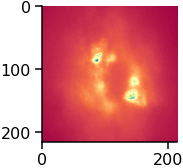

In [219]:
plt.imshow(nkx_downsample)

In [220]:
mean_intensity = img.mean(axis=0)

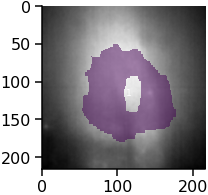

In [231]:
img_mask = nkx_downsample > np.percentile(nkx_downsample, 80)
img_mask = morphology.binary_closing(img_mask, footprint = np.ones((10,10)))

fig1, ax1 = plt.subplots(figsize=(3,3))
q = visualize.display_roi_overlay(mean_intensity, img_mask.astype(int), ax=ax1)

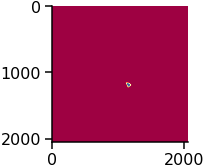

In [238]:
plt.imshow(expt_data["dmd_lightcrafter"]['target_image_space'])

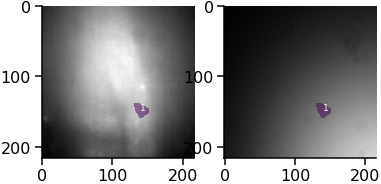

In [239]:
factor = 4
fig1, axes = plt.subplots(1,2, figsize=(6,3))
target_img_space = expt_data["dmd_lightcrafter"]['target_image_space']
# plt.imshow(target_img_space)
target_img_space = target_img_space[::factor,::factor]
offset = [(target_img_space.shape[0]-img.shape[1])//2, (target_img_space.shape[1]-img.shape[2])//2]
target_img_space = target_img_space[offset[0]:-offset[0],offset[1]:-offset[1]]
target_img_space = target_img_space.astype(bool)
q = visualize.display_roi_overlay(mean_intensity, target_img_space.astype(int), ax=axes[0])
q2 = visualize.display_roi_overlay(nkx_downsample, target_img_space.astype(int), ax=axes[1])

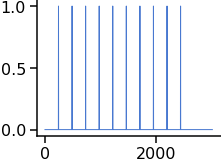

In [137]:
plt.plot(traces_dict["enable488"])

[Errno 2] No such file or directory: '/n/holyscratch01/cohen_lab/bjia/20220208_drbj009_prebeat_excitability_waveprop/stim_frames_removed/115321E19_50Hz_target4/Sq_camera.bin'
[Errno 2] No such file or directory: '/n/holyscratch01/cohen_lab/bjia/20220208_drbj009_prebeat_excitability_waveprop/corrected/115321E19_50Hz_target4/Sq_camera.bin'


/n/holyscratch01/cohen_lab/bjia/notebooks/../SpikeCounter/spikecounter/analysis/images.py:81: UserWarning: 7 frames dropped
  warnings.warn("%d frames dropped" % (fc_max - img.shape[0]))


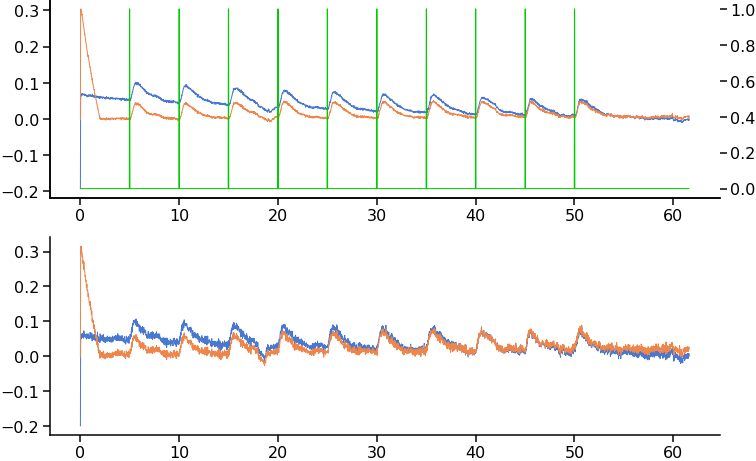

In [240]:
processes = ["stim_frames_removed", "corrected"]
fig1, axes = plt.subplots(2,1,figsize=(12,8))
for p in processes:
    img, expt_data = images.load_image(rootdir, filename, subfolder=p)
    trace_full = images.extract_mask_trace(img, mask=img_mask)
    trace_target = images.extract_mask_trace(img, mask=target_img_space)
    dff_full = traces.intensity_to_dff(trace_full)
    dff_target = traces.intensity_to_dff(trace_target)
    axes[0].plot(t,dff_full)
    axes[1].plot(t,dff_target)
ax3 = axes[0].twinx()
ax3.plot(t,traces_dict["enable488"][:len(t)], color="C2")

In [113]:
img, expt_data = images.load_image(rootdir, filename, subfolder="corrected")
dFF_corrected = images.get_image_dFF(img)

[Errno 2] No such file or directory: '/n/holyscratch01/cohen_lab/bjia/20220208_drbj009_prebeat_excitability_waveprop/corrected/104543E10_preheart_stim_50Hz_target6/Sq_camera.bin'


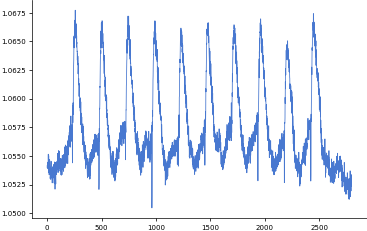

In [109]:
plt.plot(trace_target[:2800])

(1940.0, 1960.0)

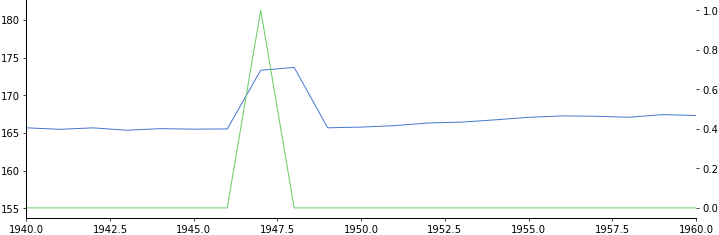

In [164]:
pks_camera, _ = signal.find_peaks(trace_target, prominence=5, width=(None,4))
pks_daq, _ = signal.find_peaks(trace_dict['enable488'])
fig1, ax1 = plt.subplots(figsize=(12,4))
ax2 = ax1.twinx()
ax1.plot(trace_target[:np.max(expt_data["frame_counter"])])
ax2.plot(trace_dict['enable488'], color="C2")
ax1.set_xlim(1940, 1960)

In [197]:
skio.imsave(os.path.join(rootdir, "analysis", "corrected_dFF_test.tif"), dFF_corrected[::4,])

/tmp/ipykernel_181489/1016276041.py:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220208_drbj009_prebeat_excitability_waveprop/analysis/corrected_dFF_test.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", "corrected_dFF_test.tif"), dFF_corrected[::4,])


## Make nice combined images

In [19]:
smoothed_vid = skio.imread(os.path.join(rootdir, "analysis", subfolder, filename, "spline_smoothed_vid.tif"))

In [20]:
smoothed_vid[:,np.isnan(tsmoothed)] = np.nan

NameError: name 'tsmoothed' is not defined

In [299]:
sta_delta = smoothed_vid - 1
combined_stack = np.array([sta_delta, np.tile(nkx_downsample, (sta_delta.shape[0],1,1)),\
                          np.tile(target_img_space, (sta_delta.shape[0],1,1))]).astype(np.float32)
combined_stack = np.flip(combined_stack, axis=2)

In [300]:
combined_stack.shape

(3, 220, 216, 216)

In [301]:
os.makedirs(os.path.join(figdir, "Figure3", "SM1"), exist_ok=True)
skio.imsave(os.path.join(figdir, "Figure3", "SM1", "%s_merged.tif" % filename), combined_stack)

In [241]:
beta = np.load(os.path.join(rootdir, "analysis", subfolder, "%s_snapt.npz") % filename)["beta"]

In [9]:
um_per_px = 0.265*4

In [243]:
q = images.analyze_wave_dynamics(beta, dt, um_per_px, deltax=13)

/n/holyscratch01/cohen_lab/bjia/notebooks/../SpikeCounter/spikecounter/analysis/images.py:616: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  p, res, _, _ = np.linalg.lstsq(A, b)


In [244]:
tsmoothed = np.copy(q[2])
tsmoothed -= np.nanpercentile(tsmoothed, 2)

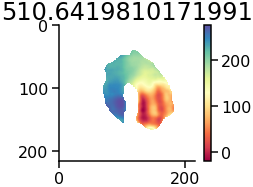

In [245]:
plt.imshow(tsmoothed)
plt.title(q[0][1])
plt.colorbar()

323.6630429132522


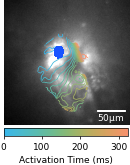

In [61]:
with plt.style.context("/n/home11/bjia/bio_publications.mplstyle"):
    fig1, ax1 = plt.subplots(figsize=(2.3,2.3))

    im = ax1.contour(tsmoothed, vmin=0, \
                   vmax=np.nanpercentile(tsmoothed,99), levels=16, \
                     cmap = plt.get_cmap("cet_CET_I1"))
    vmax = np.nanpercentile(tsmoothed,99)
    alpha=1
    target_mask = np.ma.masked_where(target_img_space==0, target_img_space)
    ax1.imshow(nkx_downsample, cmap="gray", vmax=np.percentile(nkx_downsample, 99))
    ax1.imshow(target_mask, interpolation='none', alpha=alpha, cmap="cet_CET_L15",\
               vmin=0, vmax = np.max(target_img_space), zorder=4)
    norm = mpl.colors.Normalize(vmin=0, \
                   vmax=vmax)
    print(vmax)

    plt.gca().invert_yaxis()
    cax = plt.axes([0.13, 0.06, 0.75, 0.05])
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=im.cmap, norm=norm, orientation="horizontal")
    cb1.set_label("Activation Time (ms)")
    # cax.yaxis.set_ticks([0,100,200,300])

    # cb1.set_ticks(np.linspace(0, vmax, 4))
    # cax = plt.axes([0.85, -0.25, 0.01, 1])
    # cbar = plt.colorbar(q, cax=cax)
    # cax.set_ylabel("Activation Time (ms)", size=9)
    # cax, kw = mpl.colorbar.make_axes(ax1, location="right", fraction=0.1, \
    #                                 shrink=0.9, pad=0.04)
    # cb1 = mpl.colorbar.ColorbarBase(cax, cmap=im.cmap, norm=norm,\
    #                                 orientation="vertical")
    # cax.yaxis.set_ticks([0,100,200,300])
    # plt.setp(cax.get_yticklabels(), fontsize=9)
    # cb1.set_label("Activation Time (ms)", fontsize=10)
    # ax1.set_xlim((15,175))
    # ax1.set_ylim((15,175))

    # ax1.text(5, 195, "CoChR-GFP", fontsize=10, color="white")
    # ax1.text(5, 175, "Target", fontsize=10, color="blue")


    ax1.set_axis_off()
    visualize.plot_img_scalebar(fig1, ax1, 160, 23, 50, 3,\
                    pix_per_um=1/um_per_px, yax_direction="up")
    # plt.tight_layout()
    plt.savefig(os.path.join(figdir, "Figure3",\
                             "evoked_wave_%s.tif" % filename), dpi=600)

### Compare wave propagation speeds

In [10]:
selected_experiments = ["102238E10_preheart_stim_50Hz_target1", "102633E10_preheart_stim_50Hz_target2",\
                       "103918E10_preheart_stim_50Hz_target4", "111551E14_preheart_stim_50Hz_target4",\
                       "111737E14_preheart_stim_50Hz_target5","112411E14_preheart_stim_50Hz_target7",\
                       "114629E19_50Hz_target1", "114835E19_50Hz_target2", "115321E19_50Hz_target4"]

In [11]:
expts = expts_by_embryo.reset_index()

In [12]:
expts_selected_fast = expts.iloc[[8,9,12,22,23,25,31,32,34]].copy()

/n/holyscratch01/cohen_lab/bjia/notebooks/../SpikeCounter/spikecounter/analysis/images.py:616: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  p, res, _, _ = np.linalg.lstsq(A, b)


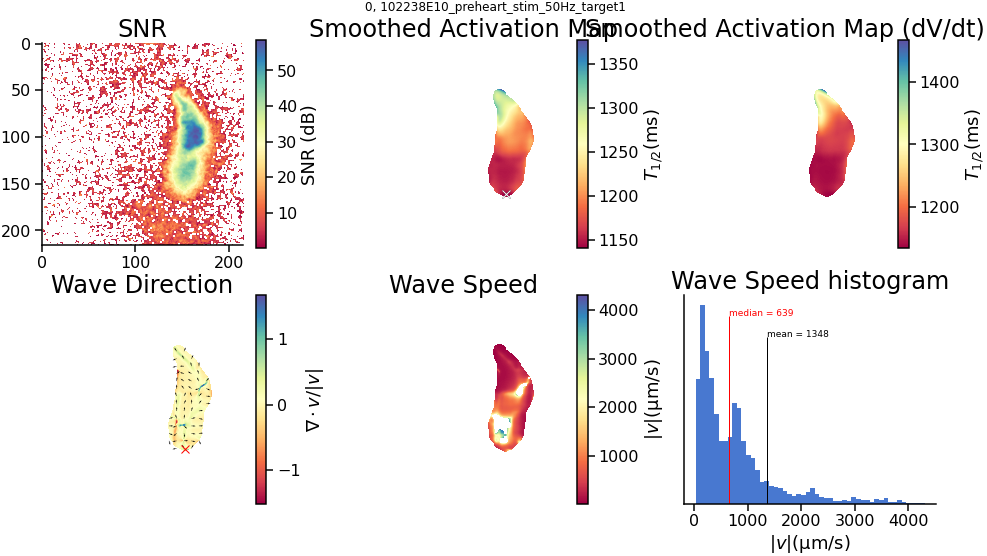

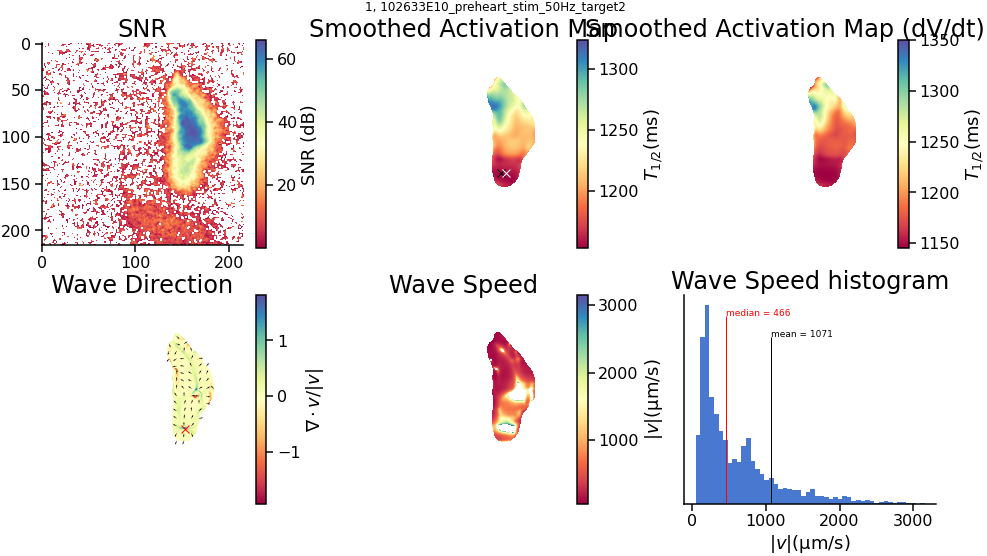

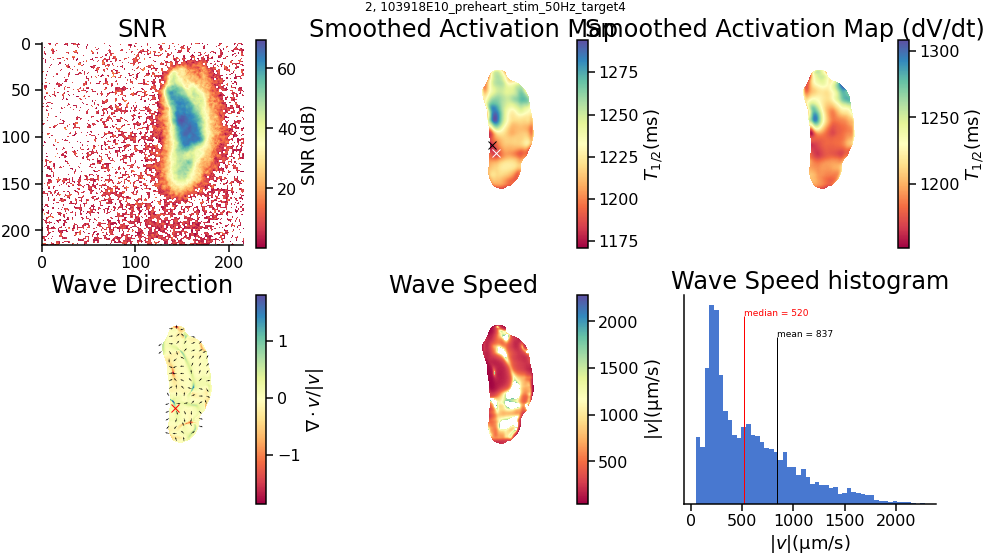

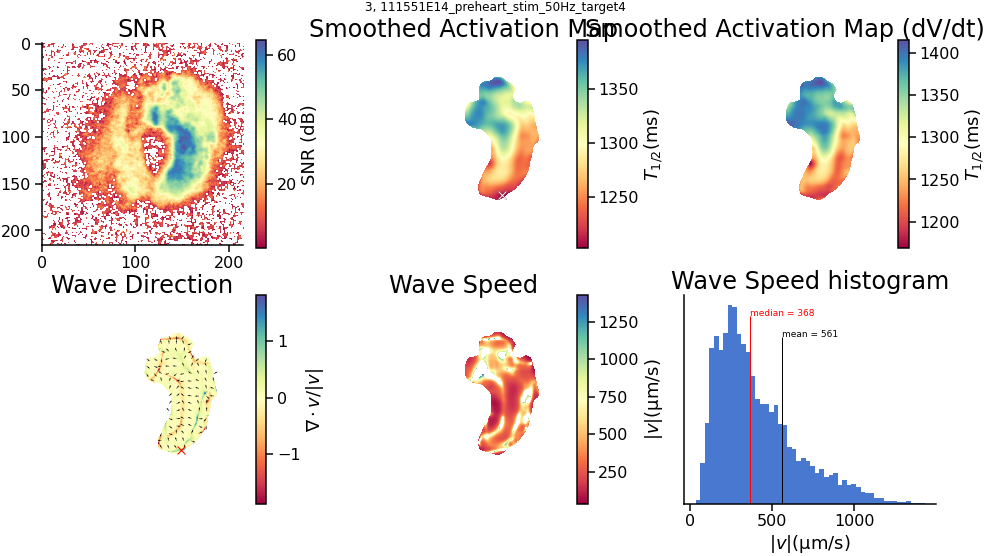

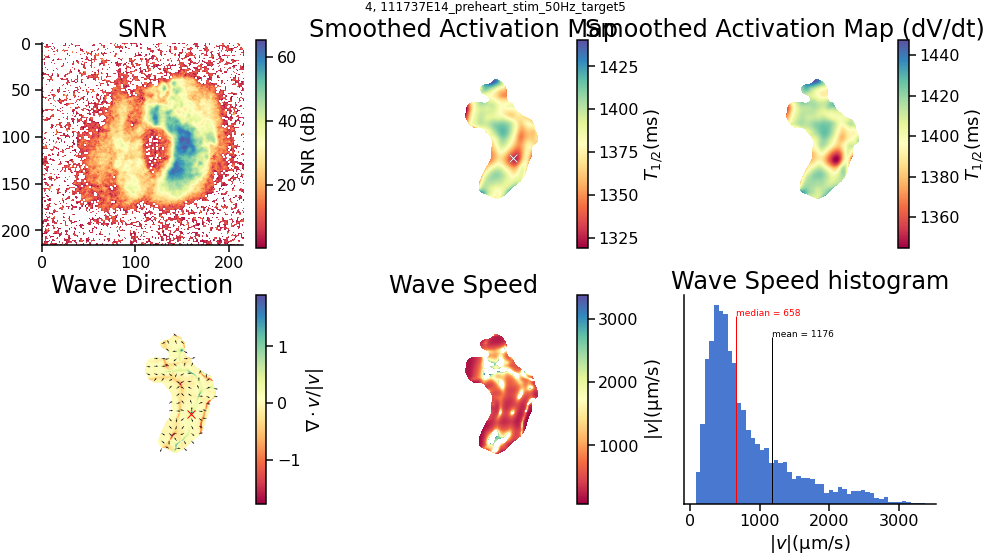

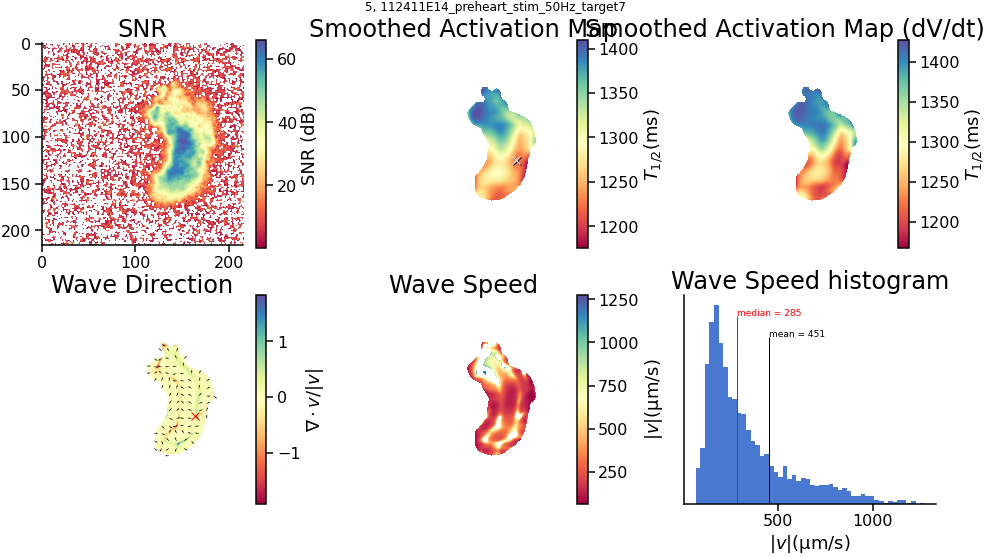

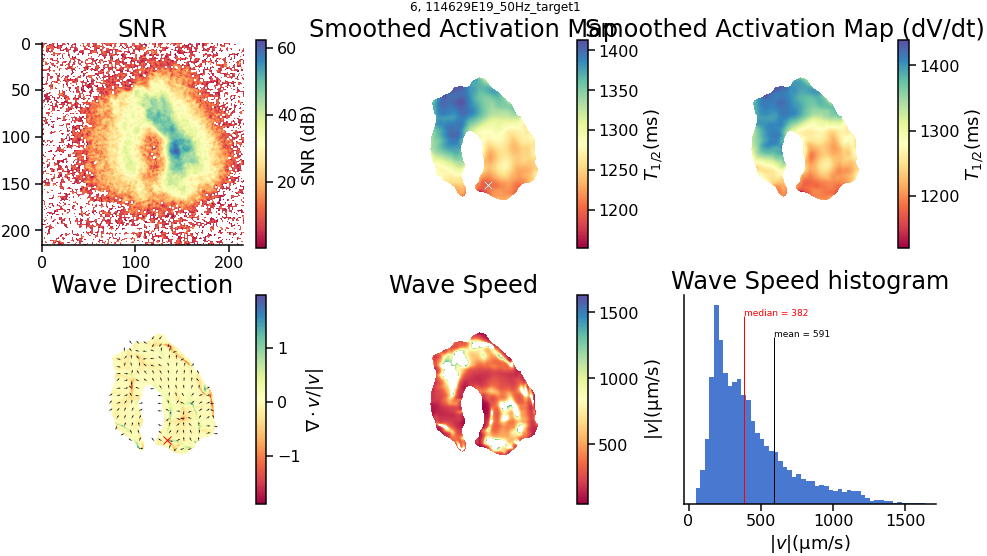

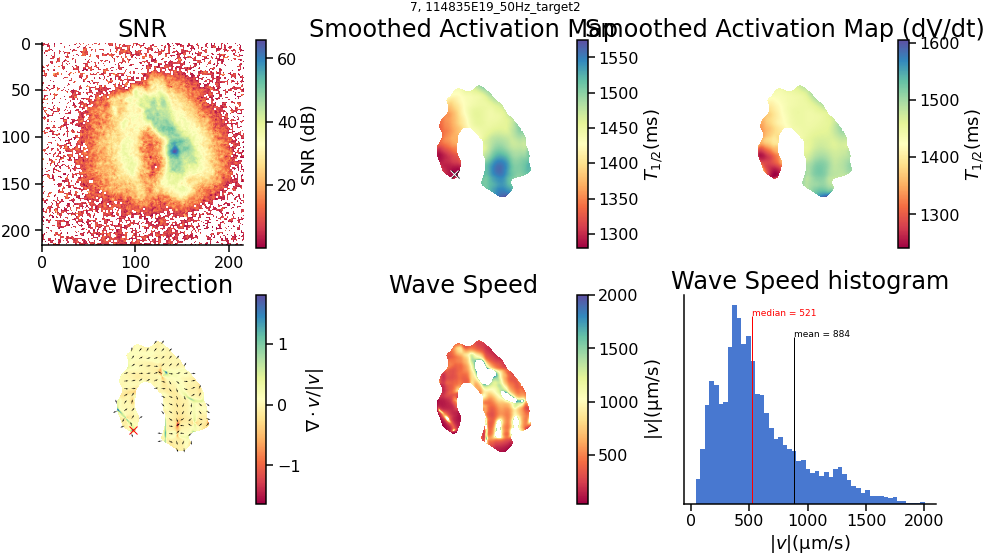

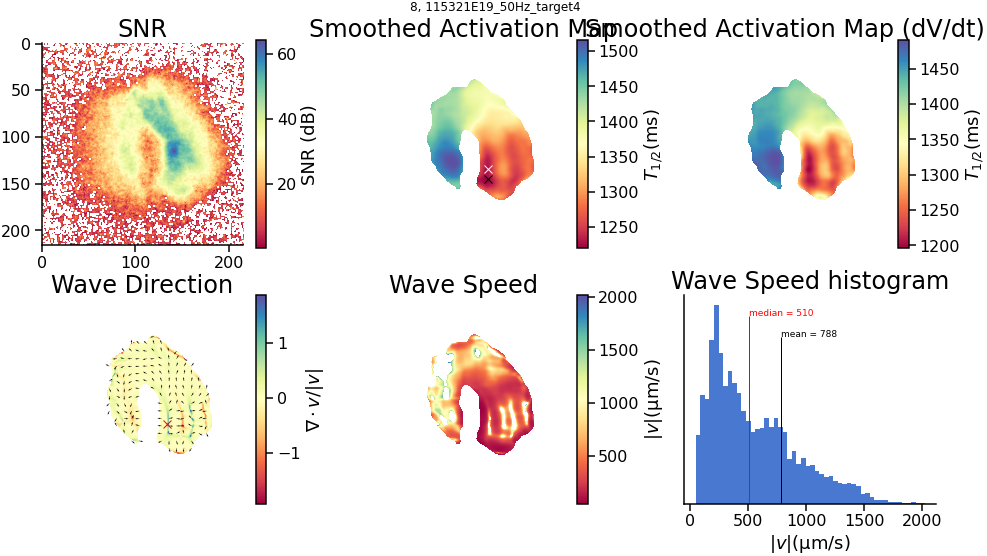

In [13]:
plt.close("all")
data = []
mint = []
maxdiv = []
erred_files = {}
smoothed_ts = {}
smoothed_ts_dv = {}
amplitudes = {}
divergences = {}
velocities = {}
for i in range(expts_selected_fast.shape[0]):
    filename = expts_selected_fast.iloc[i]["file_name"]
    snapt = "%s_snapt.npz" % filename
    if snapt in os.listdir(os.path.join(rootdir, "analysis", subfolder)):
        matdata = mat73.loadmat(os.path.join(rootdir, filename, "output_data_py.mat"))["dd_compat_py"]
        ddict, t = utils.traces_to_dict(matdata)
        dt = np.mean(np.diff(t))
        
        beta = np.load(os.path.join(rootdir, "analysis", subfolder, snapt))["beta"]

        try:
            amplitude = (np.abs(beta[2] - 1)/beta[5])**2 #SNR
            db = 20*np.log10(amplitude)
            db[db < 0] = np.nan
            q = images.analyze_wave_dynamics(beta, dt, um_per_px, deltax=13)
            if q is None:
                continue
            else:
                rd, Tsmoothed, Tsmoothed_dv, divergence, v = q
            rowdata = tuple(expts_selected_fast.iloc[i]) + rd
            data.append(rowdata)
#             print(rowdata)
        except Exception as e:
#             raise(e)
            print(e)
            erred_files[filename] = e
            continue
        
        smoothed_ts[filename] = Tsmoothed_dv
        amplitudes[filename] = beta[2]
        divergences[filename] = divergence
        velocities[filename] = v
        visualize.plot_wave_analysis(db, rd, Tsmoothed, Tsmoothed_dv,\
                           divergence, v, "%d, %s" % (i, expts_selected_fast.iloc[i]["file_name"]))
        plt.savefig(os.path.join(rootdir, "analysis", subfolder, filename, "waveplots.tif"))
        
data = pd.DataFrame(data, columns = expts_selected_fast.columns.tolist() + ['mean_speed', 'median_speed', 'loi_x',\
                                                                  'loi_y', 'loi_x_dv', 'loi_y_dv'])

In [15]:
import pickle

In [16]:
wavemaps = {}
wavemaps["velocity"] = velocities
wavemaps["divergence"] = divergences
wavemaps["smoothed_ts"] = smoothed_ts
with open(os.path.join(rootdir, "analysis", subfolder, "wavemaps2.pickle"), "wb") as f:
    pickle.dump(wavemaps, f)

In [251]:
data.to_csv(os.path.join(rootdir, "analysis", subfolder, "selected_stim_waveprops.csv"), index=False)

In [128]:
endogenous_activity = pd.read_csv(os.path.join("/n/cohen_lab/Lab/Papers/2022 First Heartbeat/Figures/Data/Figure4/wave_propagation_filtered.csv"))

In [129]:
filtered_endo = endogenous_activity[endogenous_activity['freq'] < 0.153].copy()

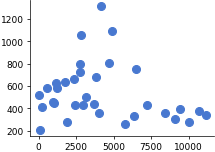

In [130]:
plt.scatter(filtered_endo["offset"], filtered_endo["median_speed"])

In [131]:
filtered_endo["evoked"] = "Endo."
data["evoked"] = "Evoked"

In [132]:
comparison_data = pd.concat([filtered_endo, data], axis=0)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Endo. vs. Evoked: Mann-Whitney-Wilcoxon test two-sided, P_val:1.860e-01 U_stat=9.400e+01


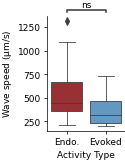

In [133]:
with plt.style.context("/n/home11/bjia/bio_publications.mplstyle"):
    x = "evoked"
    y = "median_speed"
    cs = [np.array([169,31,36,255])/255, np.array([83,154,211,255])/255]
    fig1, ax1 = plt.subplots(figsize=(2,2.5))
    sns.boxplot(data=comparison_data, x=x, y=y,\
                ax=ax1, order=["Endo.", "Evoked"], palette=cs)
    ax1.set_ylabel(r"Wave speed ($\mathrm{\mu m/s}$)")
    ax1.set_xlabel("Activity Type")
    # ax1.set_ylim(0, 1)
    pairs = [("Endo.", "Evoked")]


    annot = Annotator(ax1, pairs, data=comparison_data, x=x,y=y)
    annot.configure(test="Mann-Whitney", verbose=2, loc="outside")
    annot.apply_and_annotate()
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "Figure3", "wave_speed_endogenous_vs_evoked.svg"))

In [134]:
print(np.median(filtered_endo["median_speed"]))
print(np.median(data["median_speed"]))

446.12214230940776
314.55609308117437
